# Reindexing with Ingest Pipelines

In [36]:
import os
from dotenv import load_dotenv
load_dotenv(".env", override=True)

from elasticsearch import Elasticsearch

es = None

if 'ELASTIC_CLOUD_ID' in os.environ:
  es = Elasticsearch(
    cloud_id=os.environ['ELASTIC_CLOUD_ID'],
    basic_auth=(os.environ['ELASTIC_USER'], os.environ['ELASTIC_PASSWORD']),
    request_timeout=30
  )
elif 'ELASTIC_URL' in os.environ:
  es = Elasticsearch(
    os.environ['ELASTIC_URL'],
    basic_auth=(os.environ['ELASTIC_USER'], os.environ['ELASTIC_PASSWORD']),
    request_timeout=30
  )
else:
  print("env needs to set either ELASTIC_CLOUD_ID or ELASTIC_URL")

if es:
    print(es.info()['tagline']) # should return cluster info

You Know, for Search


In [37]:
## Utility functions from week 2
from elasticsearch import Elasticsearch, helpers
from tqdm import tqdm

def delete_index(index_name):
    if es.indices.exists(index=index_name):
        print(f"Index '{index_name}' exists. Deleting...")
        # Delete the index
        es.indices.delete(index=index_name)
        print(f"Index '{index_name}' deleted.")

def create_index_with_mapping(index_name, properties, dynamic_templates=None):
    # Check if the index exists, and if not, create it
    if not es.indices.exists(index=index_name):
        es.indices.create(index=index_name)
    
    if(dynamic_templates):
        response = es.indices.put_mapping(properties=properties, index=index_name, dynamic_templates=dynamic_templates )
    else:
        response = es.indices.put_mapping(properties=properties, index=index_name )

def batchify(docs, batch_size):
    for i in range(0, len(docs), batch_size):
        yield docs[i:i + batch_size]

def bulkLoadIndex(index_name, json_docs ):
    batches = list(batchify(json_docs, BATCH_SIZE))

    for batch in tqdm(batches, desc=f"Batches of size {BATCH_SIZE}"):
        # Convert the JSON documents to the format required for bulk insertion
        bulk_docs = [
            {
                "_op_type": "index",
                "_index": index_name,
                "_source": doc
            }
            for doc in batch
        ]

        # Perform bulk insertion
        success, errors =  helpers.bulk(es, bulk_docs, raise_on_error=False)
        if errors:
            for error in errors:
                print(error)

def changeEsRefreshInterval(es, index_name, refresh_interval):
    body = {
        "index": {
            "refresh_interval": refresh_interval
        }
    }
    response = es.indices.put_settings(index=index_name, body=body)


For this exercise we are going to grab a dataset of trees in Washington DC

[https://opendata.dc.gov/datasets/urban-forestry-street-trees/explore](https://opendata.dc.gov/datasets/urban-forestry-street-trees/explore)

![geo download](img/geodownload.jpg)
Download the latest data and put it in ```data/Urban_Forestry_Street_Trees.geojson```

Now, let's loop through a data set

In [38]:
import json


# Load the GeoJSON file
with open('data/Urban_Forestry_Street_Trees.geojson', 'r') as file:
    data = json.load(file)

Print out a single record to take a look at it

In [39]:
print( data["features"][0] )

{'type': 'Feature', 'properties': {'OBJECTID': 34866952, 'FACILITYID': '36539-040-3001-0149-000', 'VICINITY': '400 blk NORTH CAROLINA AVE SE', 'WARD': 6, 'TBOX_L': 9.0, 'TBOX_W': 4.0, 'WIRES': 'None', 'CURB': 'Permanent', 'SIDEWALK': 'Permanent', 'TBOX_STAT': 'Plant', 'RETIREDDT': None, 'SCI_NM': 'Zelkova serrata', 'CMMN_NM': 'Japanese zelkova', 'DATE_PLANT': None, 'DBH': 6.4, 'DISEASE': None, 'PESTS': None, 'CONDITION': 'Good', 'CONDITIODT': '2020-12-30T22:17:58Z', 'OWNERSHIP': 'UFA', 'TREE_NOTES': None, 'ONEYEARPHOTO': None, 'SPECIALPHOTO': None, 'PHOTOREMARKS': None, 'ELEVATION': 'Unknown', 'SIGN': 'Unknown', 'TRRS': None, 'WARRANTY': 'Unknown', 'FAM_NAME': 'Ulmaceae', 'CREATED_USER': None, 'CREATED_DATE': None, 'EDITEDBY': 'sbanua', 'LAST_EDITED_USER': 'sward', 'LAST_EDITED_DATE': '2020-12-30T22:18:21Z', 'GENUS_NAME': 'Zelkova', 'GIS_ID': None, 'GLOBALID': '{8CE96048-ABFD-40CD-8085-5F5F4F9361F0}', 'CREATOR': None, 'CREATED': None, 'EDITOR': None, 'EDITED': None, 'MBG_WIDTH': 19.685

First we'll upload the data to a staging index as-is, with a simple mapping to control the indexing.

In [40]:
import sys

index_name = "dc_urban_forestry_staging"
delete_index(index_name=index_name)

dynamic_templates = [
            {"strings_as_keywords":{
                "match_mapping_type":"string",
                "mapping": { "type": "keyword"}
            }}
        ]

properties =  {
        "properties.CONDITIODT": {     "type": "date"},
        "properties.LAST_EDITED_DATE": {     "type": "date"},
        "properties.DATE_PLANT": {   "type": "date"},
        "geometry": {     "type": "geo_shape"}
    }
    

create_index_with_mapping(index_name=index_name, 
                          properties=properties,
                          dynamic_templates=dynamic_templates)



BATCH_SIZE = 100
changeEsRefreshInterval(es,index_name=index_name,refresh_interval="30s")
bulkLoadIndex(index_name,data["features"])

# single_doc = data["features"][0]
# response = es.index(index=index_name, document=single_doc)



/var/folders/k9/1gwggc7n2yg1zq_gsfsfsb3w0000gn/T/ipykernel_20746/2328222494.py:52: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'settings' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.indices.put_settings(index=index_name, body=body)
Batches of size 100: 100%|██████████| 2080/2080 [02:13<00:00, 15.63it/s]


Merge the data and set the refresh interval back to 1 second.

In [41]:
## Geo goes faster if you force a merge
response = es.indices.forcemerge(index=index_name, max_num_segments=1)
changeEsRefreshInterval(es,index_name=index_name,refresh_interval="1s")

/var/folders/k9/1gwggc7n2yg1zq_gsfsfsb3w0000gn/T/ipykernel_20746/2328222494.py:52: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'settings' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.indices.put_settings(index=index_name, body=body)


## Plotting in Python Notebooks

This data is now loaded and ready to look at with Kibana. Often, building apps on a data set should start with a browse around Kibana to see just how dirty the data is or what kinds of values we can find in the various fields.

![Kibana](img/kibana.jpg)

I noticed a few things. I wanted to learn where the oldest trees in DC were, but there is no AGE metric in the data. Generating a bucket with an **average** age requires a number, not a date.

There is a DATE_PLANT field with the date of planting, but it is only populated for half the records. This is good place to learn how to do a transform on the data.


In [42]:
print(es.count(index=index_name)["count"], "\trecords in all")

print(es.count(index=index_name, query={
    "exists": { "field": "properties.DATE_PLANT" }
  })["count"], "\trecords with a DATE_PLANT field")

207957 	records in all
94751 	records with a DATE_PLANT field


We can see here that it is not populated consistently.  More than half the records are missing a plant date.

We can plot data by running an aggregation and plotting the results in the Python Notebook itself.

In [43]:
! pip install -qqq matplotlib

In [44]:
from datetime import datetime

index_name = "dc_urban_forestry_staging"
today_date = datetime.now().strftime('%Y-%m-%dT00:00:00Z')

query = {
    "range": {
        "properties.DATE_PLANT": {
            "gte": "1990-01-01T00:00:00Z",
            "lt": today_date
        }
    }
}
aggs = {
    "histogram_agg": {"date_histogram":{"field":"properties.DATE_PLANT", "calendar_interval": "year"}}
}
results = es.search(index=index_name, aggs=aggs, size=0, query=query)

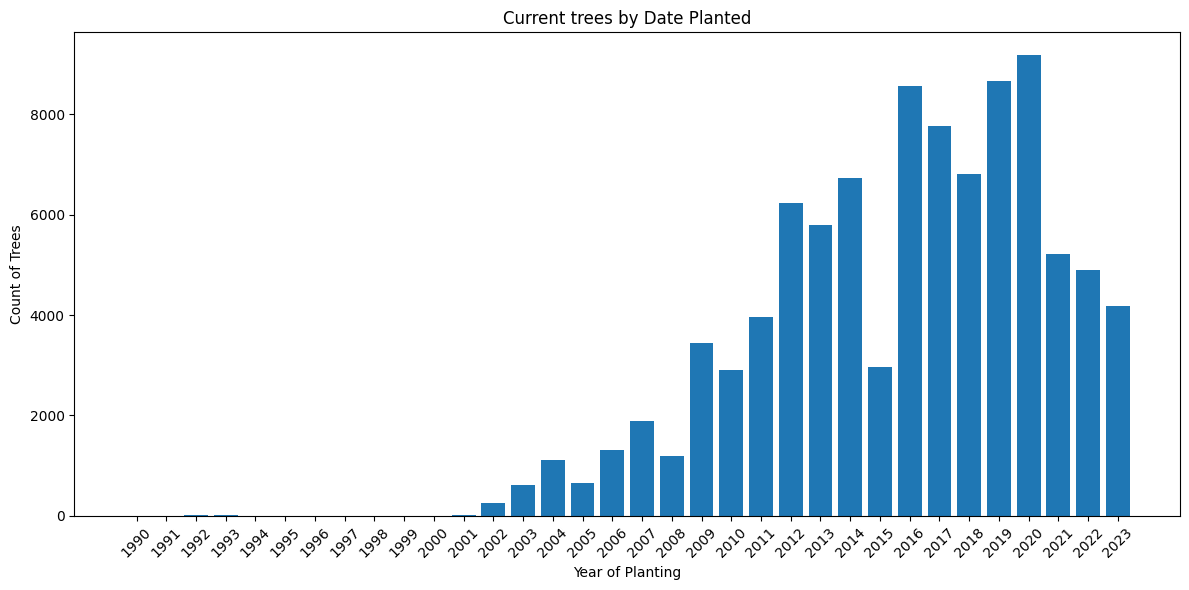

In [45]:
import matplotlib.pyplot as plt

# Extract bucket data
buckets = results['aggregations']['histogram_agg']['buckets']
dates = [bucket['key_as_string'][:4] for bucket in buckets]
counts = [bucket['doc_count'] for bucket in buckets]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(dates, counts, align='center')
plt.title("Current trees by Date Planted")
plt.xlabel("Year of Planting")
plt.ylabel("Count of Trees")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Pipeline to generate Age

Let's give ourselves the exercise of computing an age value using a pipeline. The best time to do this sort of data cleanup is on ingest. While this is trivial in Python, learning how to do it with an intermediate technology has operational advantages.  

* full ETL tools are likely the best enterprise option, but have steeper adoption curves
* Runtime fields put a query-time computational burden on Elasticsearch we can avoid.
* Logstash ... is the old way of doing things and will require extracting data already loaded into Elasticsearch

Ingest processors have the advantage of being easily insertable to existing streaming Elasticsearch ingest situations through addition of a "pipeline" parameter in addition to having an easy way to re-process data in Elasticsearch without having to first extract it back to your linux environment (which may require some heavy network performance and data exfil costs)

Let's run the following ingest processor on a single record using the simulate command.

In [46]:
index_name = "dc_urban_forestry_staging"
today_date = datetime.now().strftime('%Y-%m-%dT00:00:00Z')

processors = [
    {"script": {
        "lang": "painless",
        "source": """
String date_planted = ctx["properties"]["DATE_PLANT"];
if(date_planted != null){
    ZonedDateTime now = ZonedDateTime.parse("""+  f"\"{today_date}\""   +""");
    ZonedDateTime zdt = ZonedDateTime.parse(date_planted);
    ctx["properties"]["AGE_DAYS"]  = (now.getMillis() - zdt.getMillis()) / 86400000;
}
"""
    }}
]
es.ingest.put_pipeline(id="tree_cleanup", processors=processors)

docs = [
    {
        "_source": data["features"][0] 
    }
]

es.ingest.simulate(id='tree_cleanup', docs=docs).body["docs"][0]["doc"]["_source"]


{'type': 'Feature',
 'geometry': {'coordinates': [-77.00004838634366, 38.88589796240139],
  'type': 'Point'},
 'properties': {'DATE_PLANT': None,
  'WIRES': 'None',
  'GENUS_NAME': 'Zelkova',
  'RETIREDDT': None,
  'CREATED_DATE': None,
  'SIDEWALK': 'Permanent',
  'DBH': 6.4,
  'LAST_EDITED_DATE': '2020-12-30T22:18:21Z',
  'OBJECTID': 34866952,
  'VICINITY': '400 blk NORTH CAROLINA AVE SE',
  'TREE_NOTES': None,
  'CREATOR': None,
  'TRRS': None,
  'DTM_MEAN': 76.33305924,
  'FACILITYID': '36539-040-3001-0149-000',
  'SIGN': 'Unknown',
  'MAX_CROWN_HEIGHT': 34.85460636,
  'GLOBALID': '{8CE96048-ABFD-40CD-8085-5F5F4F9361F0}',
  'LAST_EDITED_USER': 'sward',
  'TBOX_STAT': 'Plant',
  'CREATED_USER': None,
  'CICADA_SURVEY': None,
  'SPECIALPHOTO': None,
  'SCI_NM': 'Zelkova serrata',
  'MBG_LENGTH': 26.24671999,
  'MBG_ORIENTATION': 0.0,
  'EDITED': None,
  'DISEASE': None,
  'CONDITION': 'Good',
  'GIS_ID': None,
  'CURB': 'Permanent',
  'MIN_CROWN_BASE': 0.60263501,
  'PHOTOREMARKS': N

With that working we can do queue up a reindex.  It will process in the background, but if we grab the task_id we can query to see when it is done.

In [51]:
delete_index(index_name="dc_urban_forestry")

dynamic_templates = [
            {"strings_as_keywords":{
                "match_mapping_type":"string",
                "mapping": { "type": "keyword"}
            }}
        ]

properties =  {
        "properties.CONDITIODT": {     "type": "date"},
        "properties.LAST_EDITED_DATE": {     "type": "date"},
        "properties.DATE_PLANT": {   "type": "date"},
        "geometry": {     "type": "geo_shape"}
    }
    

create_index_with_mapping(index_name="dc_urban_forestry", 
                          properties=properties,
                          dynamic_templates=dynamic_templates)

changeEsRefreshInterval(es,index_name="dc_urban_forestry",refresh_interval="30s")


index_name = "dc_urban_forestry_staging"
source = {
    "index": index_name
}
dest_name = "dc_urban_forestry"
dest = {
    "index": dest_name,
    "pipeline": 'tree_cleanup'
}

task_id = es.reindex(source=source, dest=dest, wait_for_completion=False)["task"]
task_id

Index 'dc_urban_forestry' exists. Deleting...
Index 'dc_urban_forestry' deleted.


/var/folders/k9/1gwggc7n2yg1zq_gsfsfsb3w0000gn/T/ipykernel_20746/2328222494.py:52: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'settings' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.indices.put_settings(index=index_name, body=body)


'y9LUoTAHRiSxcoEzAbLqMA:25491279'

In [52]:
from elasticsearch.client import TasksClient
import time

tasks = TasksClient(client=es)
is_completed = False
while not is_completed:
    tasks_api = tasks.get(task_id=task_id)
    is_completed = tasks_api["completed"]
    done_count = tasks_api["task"]["status"]["created"]
    total_count = tasks_api["task"]["status"]["total"]
    print(f"Processing ... {done_count}/{total_count}")
    time.sleep(5)
print("Done")



Processing ... 24000/207957
Processing ... 49000/207957
Processing ... 74000/207957
Processing ... 99000/207957
Processing ... 124000/207957
Processing ... 148000/207957
Processing ... 173000/207957
Processing ... 199000/207957
Processing ... 207957/207957
Done


because it is geo data, let's do a force merge again and reset the refresh interval.

In [53]:
response = es.indices.forcemerge(index="dc_urban_forestry", max_num_segments=1)
changeEsRefreshInterval(es,index_name="dc_urban_forestry",refresh_interval="1s")

/var/folders/k9/1gwggc7n2yg1zq_gsfsfsb3w0000gn/T/ipykernel_20746/2328222494.py:52: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'settings' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.indices.put_settings(index=index_name, body=body)


We can now redraw the aggregation with our new field.

In [54]:
from datetime import datetime

index_name = "dc_urban_forestry"
today_date = datetime.now().strftime('%Y-%m-%dT00:00:00Z')

query = {
    "range": {
        "properties.DATE_PLANT": {
            "gte": "1990-01-01T00:00:00Z",
            "lt": today_date
        }
    }
}
aggs = {
    "age_agg": {"histogram":{"field":"properties.AGE_DAYS", "interval": 1}}
}
results = es.search(index=index_name, aggs=aggs, size=0, query=query)

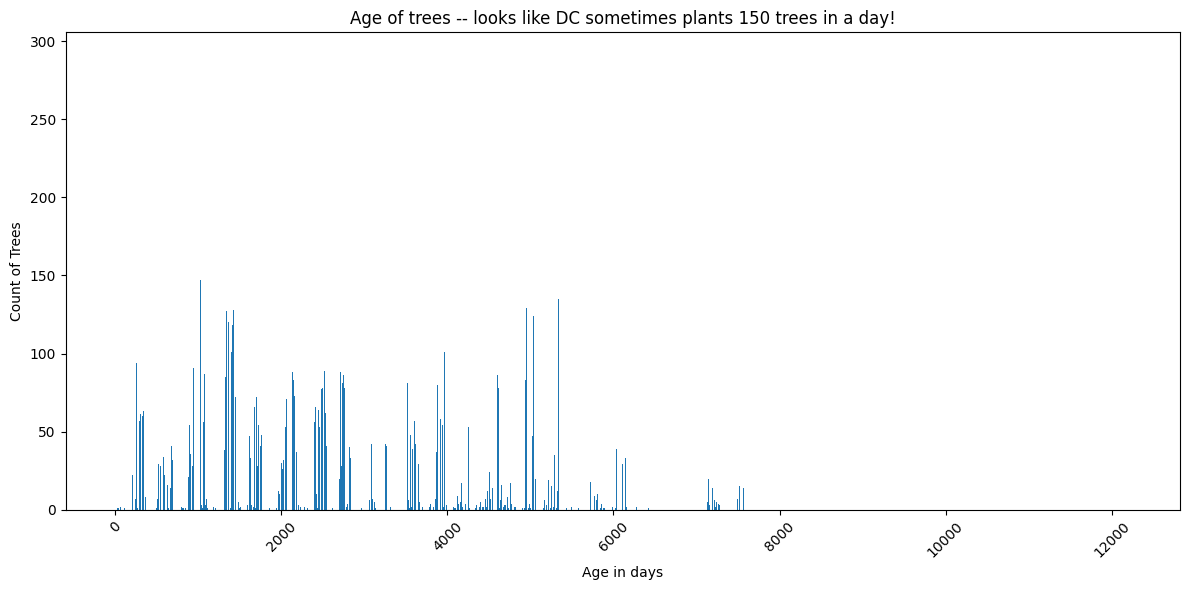

In [55]:
import matplotlib.pyplot as plt

# Extract bucket data
buckets = results['aggregations']['age_agg']['buckets']
dates = [bucket['key'] for bucket in buckets]
counts = [bucket['doc_count'] for bucket in buckets]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(dates, counts, align='center')
plt.title("Age of trees -- looks like DC sometimes plants 150 trees in a day!")
plt.xlabel("Age in days")
plt.ylabel("Count of Trees")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()